<h2>Define Functions</h2>

In [49]:
import evaluate
import vad_utils
import matplotlib.pyplot as plt
import numpy as np
import wave
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

#计算短时过零率
def compute_zero(signal):
    zcr = 0
    sign = np.sign(signal)
    for i in range(len(sign)-1):
        zcr += abs(sign[i]-sign[i+1])
    zcr /= 2
    return zcr

#计算短时能量
def compute_energy(signal):
    energy = 0
    for i in range(len(signal)):
        energy += signal[i]*signal[i]
    return energy

#用于制作训练集
def process_train(f, vad_label):
    #读取音频信号f(.wav文件)的信息(帧数,按帧的信号序列,无语音特征),参考:https://blog.csdn.net/YAOHAIPI/article/details/102826051
    res_label = vad_label #保存用提供函数得到的字典
    params = f.getparams() #获取wav文件的参数
    nchannels, sampwidth, framerate, nframes = params[:4] #赋值声道数，量化位数，采样频率，采样点数
    wlen = int(0.032 * framerate) #一帧0.032s对应帧数
    inc = int(0.010 * framerate) #帧移0.01s对应帧数
    str_data = f.readframes(nframes) #指定需要读取的长度(全部)
    wave_data = np.frombuffer(str_data, dtype=np.short) #转换为一维short类型的数组
    wave_data = wave_data*1.0/(max(abs(wave_data))) #归一化
    time = np.arange(0, wlen) * (1.0 / framerate) #计算取样时间
    signal_length = len(wave_data) #信号总长度
    nf = int(np.ceil((1.0*signal_length-wlen+inc)/inc)) #计算语音帧数
    pad_length = int((nf-1)*inc+wlen) #所有帧加起来总的铺平后的长度
    zeros = np.zeros((pad_length-signal_length,)) #不够的长度使用0填补
    pad_signal = np.concatenate((wave_data,zeros)) #填补后的信号记为pad_signal
    indices = np.tile(np.arange(0,wlen),(nf,1))+np.tile(np.arange(0,nf*inc,inc),(wlen,1)).T  #相当于对所有帧的时间点进行抽取，得到nf*nw长度的矩阵
    indices=np.array(indices,dtype=np.int32) #将indices转化为矩阵
    frames=pad_signal[indices] #得到帧信号

    #初始化过零率和短时能量计算结果(只用到了短时能量)
    zerores = []
    energyres = []

    #遍历每一帧，进行过零率和短时能量计算并将这帧得到的结果拼接到总结果上
    for i in range(nf):
        a = frames[i:i+1]
        
        windown=np.hanning(wlen)  #调用汉明窗
        b=a[0]*windown
        res_zero = compute_zero(b)
        res_energy = compute_energy(b)
        zerores.append(res_zero)
        energyres.append(res_energy)

    #补0使三个列表的长度一样，为nf
    while len(res_label) < nf:
        res_label.append(0)
    while len(zerores) < nf:
        zerores.append(0)
    while len(energyres) < nf:
        energyres.append(0)

    return zerores, energyres, res_label

#用于在test(作业要求)数据上做检测,使用了短时能量
def process_test(f):
    params = f.getparams()
    nchannels, sampwidth, framerate, nframes = params[:4]
    wlen = int(0.032 * framerate)
    inc = int(0.010 * framerate)
    str_data = f.readframes(nframes)
    wave_data = np.frombuffer(str_data, dtype=np.short)
    wave_data = wave_data*1.0/(max(abs(wave_data)))
    time = np.arange(0, wlen) * (1.0 / framerate)
    signal_length = len(wave_data)
    nf = int(np.ceil((1.0*signal_length-wlen+inc)/inc))
    pad_length = int((nf-1)*inc+wlen) 
    zeros = np.zeros((pad_length-signal_length,)) 
    pad_signal = np.concatenate((wave_data,zeros))
    indices = np.tile(np.arange(0,wlen),(nf,1))+np.tile(np.arange(0,nf*inc,inc),(wlen,1)).T
    indices = np.array(indices,dtype=np.int32)
    frames = pad_signal[indices]
    energyres = []

    for i in range(nf):
        a = frames[i:i+1]
        windown=np.hanning(wlen)  #调用汉明窗
        b=a[0]*windown
        res_energy = compute_energy(b)
        energyres.append(res_energy)

    while len(energyres) < nf:
        energyres.append(0)

    res = vad_utils.prediction_to_vad_label(energyres, 0.032, 0.010, 0.06) #以0.06为阈值做分类
    energyres = vad_utils.parse_vad_label(res,0.032,0.010) #得到分类的标签结果
    silence = 0
    flag = 0
    start = 1
    for i in range(len(energyres)):
        if energyres[i] == 1 & start == 1:
            start = 0
        elif energyres[i] == 0 & start == 0:
            flag = 1
            silence += 1
        elif energyres[i] == 1 & flag == 1:
            flag = 0
            if silence <= 2:
                for j in range(silence):
                    energyres[i-j-1] = 1
            silence = 0

    res = vad_utils.prediction_to_vad_label(energyres, 0.032, 0.010, 0.06) #以0.06为阈值做分类
    return res #返回string变量(例如:"0.02,0.1 0.15,0.17, 0.29,0.40")

<h2>Make Train Set</h2>

In [45]:
#制作训练集(整合所有语音,针对线性分类器方法，但最终因准确率低未采用)
vad_label = vad_utils.read_label_from_file("./data/dev_label.txt") #读取字典
train_all_zero = []
train_all_energy = []
train_all_label = []
for key in vad_label:
    f = wave.open(r"./wavs/dev/{name}.wav".format(name = key), "rb")
    zerores, res_energy, output_vad_label = process_train(f,vad_label[key])
    train_all_zero.extend(zerores)
    train_all_energy.extend(res_energy)
    train_all_label.extend(output_vad_label) #将每个语音文件的过零率、短时能量和标签list合并成3个大lists

<h2>Energy to classify on Train Set</h2>

In [47]:
energyres_text = vad_utils.prediction_to_vad_label(train_all_energy, 0.032, 0.010, 0.06)
energyres_frame = vad_utils.parse_vad_label(energyres_text,0.032,0.010) #得到分类的标签结果
while len(energyres_frame) < len(train_all_energy): #补零
    energyres_frame.append(0)

#去除短时静音
silence = 0
flag = 0
start = 1
for i in range(len(energyres_frame)):
    if energyres_frame[i] == 1 & start == 1:
        start = 0
    elif energyres_frame[i] == 0 & start == 0:
        flag = 1
        silence += 1
    elif energyres_frame[i] == 1 & flag == 1:
        flag = 0
        if silence <= 11:
            for j in range(silence):
                energyres_frame[i-j-1] = 1
        silence = 0

train_all_label_arr = np.array(train_all_label)
energyres_frame_arr = np.array(energyres_frame) #转化为numpy数组(多余)
print('Misclassified samples:%d' % (train_all_label_arr != energyres_frame_arr).sum()) #计算错分的样本
print('Accuracy: %.2f' % accuracy_score(train_all_label_arr, energyres_frame_arr)) #计算准确率
print(evaluate.get_metrics(energyres_frame, train_all_label)) #用提供的evaluate文件计算auc和eer

Misclassified samples:56724
Accuracy: 0.92
(0.9172077294042104, 0.08613758643843142)


<h2>Draw Graph</h2>

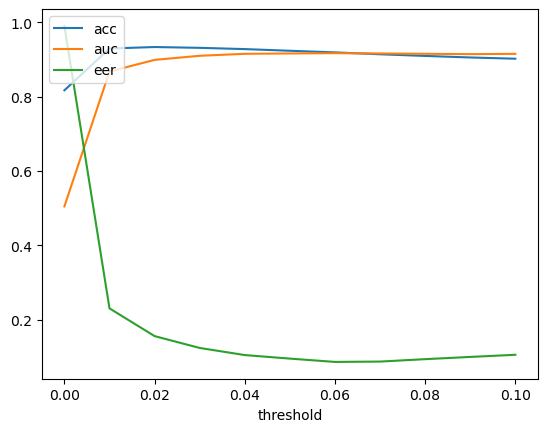

In [51]:
#随threshould变化的图
x = np.linspace(0,0.1,11) #横轴
y_acc = []
y_auc = []
y_eer = []
for threshold_energy in range(11):
    threshold_energy *= 0.01
    energyres_text = vad_utils.prediction_to_vad_label(train_all_energy, 0.032, 0.010, threshold=threshold_energy)
    energyres_frame = vad_utils.parse_vad_label(energyres_text,0.032,0.010) #得到分类的标签结果
    while len(energyres_frame) < len(train_all_energy): #补零
        energyres_frame.append(0)
    #去除短时静音
    silence = 0
    flag = 0
    start = 1
    for i in range(len(energyres_frame)):
        if energyres_frame[i] == 1 & start == 1:
            start = 0
        elif energyres_frame[i] == 0 & start == 0:
            flag = 1
            silence += 1
        elif energyres_frame[i] == 1 & flag == 1:
            flag = 0
            if silence <= 11:
                for j in range(silence):
                    energyres_frame[i-j-1] = 1
            silence = 0

    auc, eer = evaluate.get_metrics(energyres_frame, train_all_label)
    y_acc.append(accuracy_score(train_all_label, energyres_frame))
    y_auc.append(auc)
    y_eer.append(eer)
plt.plot(x,y_acc)
plt.plot(x,y_auc)
plt.plot(x,y_eer)
plt.xlabel('threshold')
plt.legend(['acc','auc','eer'],loc='upper left')
plt.show() #画图


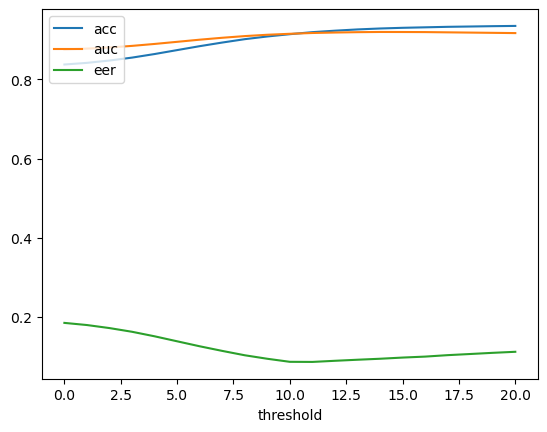

In [52]:
#随短时静音判断帧数变化图
x = np.linspace(0,20,21)
y_acc = []
y_auc = []
y_eer = []
for append_0 in range(21):
    energyres_text = vad_utils.prediction_to_vad_label(train_all_energy, 0.032, 0.010, 0.06)
    energyres_frame = vad_utils.parse_vad_label(energyres_text,0.032,0.010) #得到分类的标签结果
    while len(energyres_frame) < len(train_all_energy): #补零
        energyres_frame.append(0)
    #去除短时静音
    silence = 0
    flag = 0
    start = 1
    for i in range(len(energyres_frame)):
        if energyres_frame[i] == 1 & start == 1:
            start = 0
        elif energyres_frame[i] == 0 & start == 0:
            flag = 1
            silence += 1
        elif energyres_frame[i] == 1 & flag == 1:
            flag = 0
            if silence <= append_0:
                for j in range(silence):
                    energyres_frame[i-j-1] = 1
            silence = 0

    auc, eer = evaluate.get_metrics(energyres_frame, train_all_label)
    y_acc.append(accuracy_score(train_all_label, energyres_frame))
    y_auc.append(auc)
    y_eer.append(eer)
plt.plot(x,y_acc)
plt.plot(x,y_auc)
plt.plot(x,y_eer)
plt.xlabel('threshold')
plt.legend(['acc','auc','eer'],loc='upper left')
plt.show()


<h2>Zero Rate To Classify</h2>

In [4]:
zerores_text = vad_utils.prediction_to_vad_label_less(train_all_zero, 0.032, 0.010, 50)
zerores_frame = vad_utils.parse_vad_label(zerores_text,0.032,0.010)
while len(zerores_frame) < len(train_all_zero):
    zerores_frame.append(0)
train_all_label_arr = np.array(train_all_label)
zerores_frame_arr = np.array(zerores_frame)
print('Misclassified samples:%d' % (train_all_label_arr != zerores_frame_arr).sum())
print('Accuracy: %.2f' % accuracy_score(train_all_label_arr, zerores_frame_arr))
print(evaluate.get_metrics(zerores_frame, train_all_label))

Misclassified samples:281142
Accuracy: 0.60
(0.5854972185234455, 0.4376971842653714)


<h2>Linear Classifier To Classify</h2>

In [5]:
#利用sklearn库的逻辑回归线性分类
train_all_label = np.array(train_all_label)
train_input = np.vstack((train_all_zero, train_all_energy)).T #制作数据集
X_train, X_test, y_train, y_test = train_test_split(train_input, train_all_label, test_size = 0.3, shuffle=1) #数据集划分
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test) #标准化
ppn = LogisticRegression(penalty='l2',class_weight={0:0.7,1:0.3},max_iter=7000) #权重对结果影响很大
ppn.fit(X_train_std, y_train)
y_pred = ppn.predict(X_test_std)
print('Misclassified samples:%d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print(evaluate.get_metrics(y_pred.tolist(), y_test.tolist()))

e:\download\Anaconda\envs\pytorch_dl\Lib\site-packages\sklearn\utils\_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


Misclassified samples:40841
Accuracy: 0.81
(0.818719880152379, 0.2008465263929022)


<h2>Apply To Test Set</h2>

In [50]:
f_res = open("./result3.txt","w") #写入结果的文件
f_res.truncate(0) #清空文件
paths = os.walk(r"./wavs/test") #得到路径
for path, dir_lst, file_lst in paths:
    for file_name in file_lst: #遍历测试集的音频
        file_name = file_name.split(".")[0] #分离出文件名(不带后缀)
        f = wave.open(r"./wavs/test/{name}.wav".format(name = file_name), "rb") #读取音频
        res = process_test(f) #进行处理
        f_res.write("{name} {result}".format(name = file_name, result = res)+"\n") #将结果写入result.txt(音频按名称已排序)
f_res.close() #关闭文件